<center>
<h1>Attività Data Analytics: Gun Violence in the Unites States </h1>
Pifferi Cristiano <br>
Matricola: 172907 <br>
Università di Modena e Reggio Emilia <br>
254764@studenti.unimore.it
</center>

### 0. Introduzione
Spesso si sente parlare di sparatorie negli Stati Uniti con diversi morti. Il tema delle armi è scottante e spesso centrale in molti discorsi politici, dalla totale libertà dei Repubblicani alla timida voglia di cambiamento dei Democratici. 
Ma come sono distribuiti nei vari stati questi eventi? È presente una collocazione geografica precisa (est/ovest) o no?
Inoltre spesso si analizza anche la componente razziale di alcuni eventi. È presente una relazione tra il numero di morti e la composizione etnica della popolazione? 
Queste sono due delle domande a cui si cercherà di dare risposta.

### 1. I dataset
Entrambi i dataset trattati provengono dal CDC ([Center fo Desease Control and Prevention](https://www.cdc.gov/)):
- "Multiple Cause of Death, 1999-2020"
- "Single-Race Population Estimates 2010-2019"


Il dataset "Multiple Cause of Death, 1999-2020" contiene i dati riguardanti le morti per armi da fuoco negli anni 1999-2020 suddivisi per stato, genere e anno. Contiene i seguenti campi:

| Campo | Descrizone |
| ----------- | ----------- |
| State | Stato |
| Gender | Genere (Male, Female) |
| Year | Anno |
| Deaths | Numero di morti |

Il dataset "Single-Race Population Estimates 2010-2019" contiene i dati demografici dei singoli stati con enfasi sulle etnie della popolazione. Contiene i seguenti campi: 

| Campo | Descrizone |
| ----------- | ----------- |
| State | Stato |
| Gender | Genere (Male, Female) |
| Race | Razza: American Indian or Alaska Native, Black or Africa American, White, Asian, Native Hawaiian or Other Pacific Islander, More than one race |
| Year | Anno |
| Population | Numero di abitati |

Per il trattamento dei dati e delle successive operazioni di analisi saranno usate le seguenti liberie.
- pandas
- Scipy
- seaborn
- plotly
- matplotlib

In [14]:
import pandas as pd
import scipy.stats as sci
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

I dataset scaricati dal CDC sono in formato txt, quindi un primo passaggio sarà quello di convertirli in csv, successivamente si possono eliminare le clonne superflue. Il codice per questi passaggi è contenuto nel file "Gun-violence-in-US\Dataset\clean_data.py".
 
Carichiamo dunque i dataset e manteniamo solo i dati relativi agli anni in comune, cioè 2010-2019.

In [15]:
# import dataset
dfGun = pd.read_csv('https://raw.githubusercontent.com/CriPiffe/Gun-violence-in-US/main/Dataset/Multiple%20Cause%20of%20Death%2C%201999-2020.csv')
dfDemo = pd.read_csv('https://raw.githubusercontent.com/CriPiffe/Gun-violence-in-US/main/Dataset/Single-Race%20Population%20Estimates%202010-2019.csv')

# rimozione dati 1999-2009 e 2020
dfGun = dfGun[(dfGun['Year']>2009) & (dfGun['Year']<2020)]

dfGun.head()
dfDemo.head()

,State,Gender,Race,Year,Population
0,Alabama,Female,American Indian or Alaska Native,2010.0,16096.0
1,Colorado,Female,Black or African American,2010.0,102504.0
2,Missouri,Female,More than one race,2010.0,57312.0
3,Missouri,Female,White,2010.0,2561135.0
4,Missouri,Female,Native Hawaiian or Other Pacific Islander,2010.0,3615.0


### 2. Analisi geografica e temporale

In questo paragrafo si analizzerà la relazione tra le morti per arma da fuoco e la collocazione geografica e temporale. Le domande guida sono 2: 
- Qual è il trend temporale? Si può dire qualcosa sul futuro?
- Sono presenti zone geografiche delimitate in cui i dati sono simili?

Prima di tutto prepariamo il dataset togliendo i dati relativi alla composizione etnica che serviranno sucessivamente.

In [16]:
dffDemo = dfDemo[['State','Year','Population']].groupby(by=['State','Year'], as_index=False).sum()
dffGun=dfGun[['State','Year','Deaths']].groupby(by=['State','Year'], as_index=False).sum()

dffOnlyPopulation = pd.merge(dffGun,dffDemo, how='inner', on=['State','Year'])

dffOnlyPopulation.head(10)

,State,Year,Deaths,Population
0,Alabama,2010,781,4785437.0
1,Alabama,2011,786,4799069.0
2,Alabama,2012,832,4815588.0
3,Alabama,2013,855,4830081.0
4,Alabama,2014,813,4841799.0
5,Alabama,2015,955,4852347.0
6,Alabama,2016,1037,4863525.0
7,Alabama,2017,1122,4874486.0
8,Alabama,2018,1064,4887681.0
9,Alabama,2019,1072,4903185.0


Si è parlato di dati simili nei vari stati, ma in che senso? Serve una misura per comparare gli Stati tra loro. Tale misura la troviamo nel _crude rate_, cioè il rapporto tra morti per arma da fuoco e popolazione per ogni anno. Nel nostro caso sarà inoltre moltiplicato per 1000 in modo da rendere i numeri più fruibili.

In [17]:
crudeRate = [(nDeaths/pop)*1000 for (nDeaths, pop) in zip(dffOnlyPopulation['Deaths'], dffOnlyPopulation['Population'])]

dffOnlyPopulation.insert(loc=len(dffOnlyPopulation.columns), column='Crude Rate', value=crudeRate)

dffOnlyPopulation = dffOnlyPopulation.sort_values(by=['Crude Rate'], ascending=False)

dffOnlyPopulation.to_csv('withCrudeRate.csv', index=False)


Partiamo dalla prima domanda. Da una prima osservazione si nota come le prime posizioni siano occupate da anni recenti (2015-2019). Per verificare questa ipotesi raggruppiamo per anno e facciamo la media di tutti i crude rate dei singoli stati.

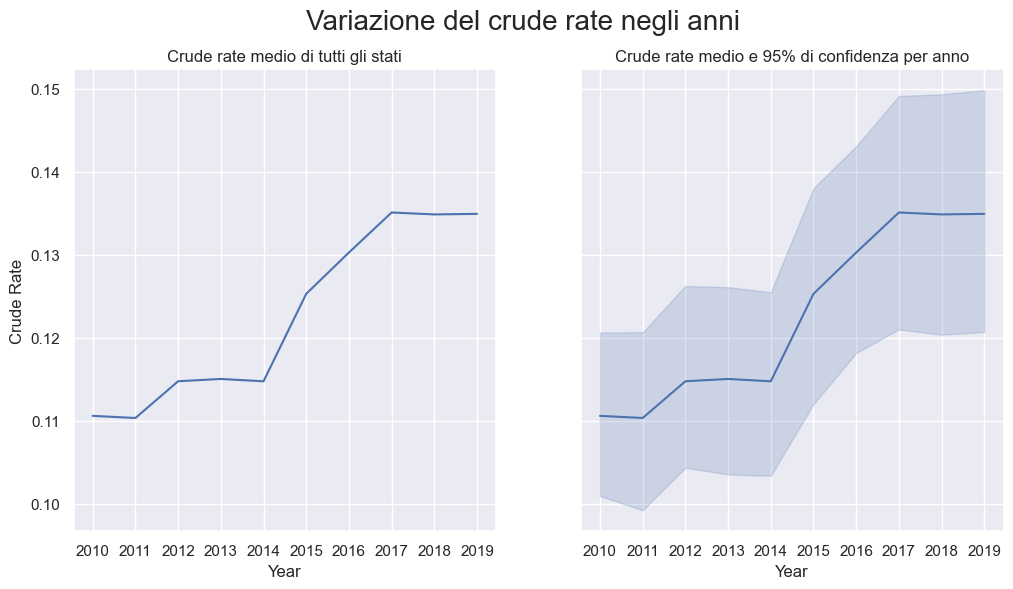

In [18]:
dfCrudeRateByYear = dffOnlyPopulation.drop(['State'], axis=1).groupby(by='Year', as_index=False).agg({'Deaths':'sum',
                                                                                                      'Population':'sum',
                                                                                                      'Crude Rate':'mean'})

#dfCrudeRateByYear.head(10)

# plot
sns.set(rc={'figure.figsize':(12,6)})
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)

plot1 = sns.lineplot(data=dfCrudeRateByYear, x='Year', y='Crude Rate', ax=axs[0])
plot2 = sns.lineplot(data=dffOnlyPopulation, x='Year', y='Crude Rate', ax=axs[1])
years = dfCrudeRateByYear['Year'].astype(str).values.tolist()

plot1.set(xticks=dfCrudeRateByYear['Year'].values)
plot2.set(xticks=dfCrudeRateByYear['Year'].values)

fig.suptitle('Variazione del crude rate negli anni', fontsize=20)
axs[0].set_title('Crude rate medio di tutti gli stati')
axs[1].set_title('Crude rate medio e 95% di confidenza per anno');


L'ipotesi è confermata, la rappresentazione grafica mostra come il crude rate (medio) aumenti nel corso degli anni, nonostante un plateau negli ultimi anni. Soprattutto negli anni 2015-2017 il crude rate è aumentato di molto, ma i dati non ci permettono di avanzare delle motivazioni, che possono risiedere nel contesto sociale, politico ed economico del paese. Altra osservazione riguarda gli anni 2018 e 2019, in cui la variazione del crude rate è minima rispetto al 2017, ma è rilevante l'intervallo di confidenza del 95%, perché ci indica come la costanza si raggiunta per via un peggioramento di alcuni stati e un miglioramento di altri. Situazione diversa rispetto agli anni 2013 e 2014, in cui la fascia del 95% si mantiene costante sia nei massimi sia nei minimi.
Si può di conseguenza ipotizzare, negli anni seguenti, un maggiore virtuosismo da parte di alcui stati, mentre il peggioramento in altri. 

Passiamo ora ad analizzare i dati in base al luogo geografico, raggruppando quindi per stato ed ordinando per crude rate maggiore per verificare se vi è presente una distribuzione geografica rilevante.

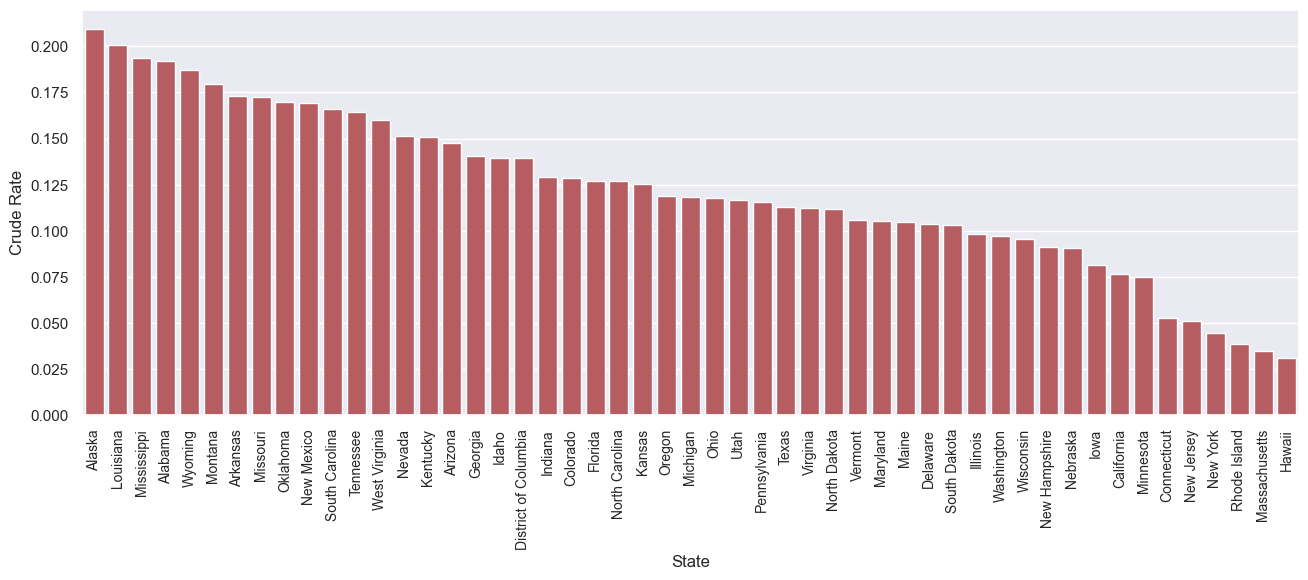

In [19]:
dfMean = dffOnlyPopulation.drop('Year', axis=1).groupby(by='State', as_index=False).mean()

dfMean = dfMean.sort_values(by=['Crude Rate'], ascending=False)

# plot con grafico a barre
sns.set(rc={'figure.figsize':(15.7,5.27)})
plot =sns.barplot(dfMean, x='State', y='Crude Rate', color='r' )

plot.set_xticklabels(plot.get_xticklabels(), rotation=90, size = 10);

Si osserva come, tolta l'Alaska, gli stati con crude rate più alto siano Louisiana, Mississippi e Alabama che sono geograficamente situati nel sud-est del paese. Questo fenomeno è confermato saltando due posizioni e notando come anche Arkansas, Missouri e Oklahoma abbiano un valore maggiore a 0.17, spostando il polo geografico verso il centro. Si delimita quindi una regione di stati confinanti con popolazione rilevante (più di un milione di abitanti ciascuno) con un crude rate consistente ed elevato. 

Fenomeno simile si osserva negli stati più "diligenti", che si collocano nel nord-est del paese: Massachusetts, Rhode Island, New York, New Jersey e Connecticut. 

Nella mappa sottostante è possibile verificare questo andamento.

In [20]:
# plot della mappa
# aggiungo al dataset i codici degli stati per poter plottare nella mappa
state_codes = {
    'District of Columbia' : 'dc','Mississippi': 'MS', 'Oklahoma': 'OK', 
    'Delaware': 'DE', 'Minnesota': 'MN', 'Illinois': 'IL', 'Arkansas': 'AR', 
    'New Mexico': 'NM', 'Indiana': 'IN', 'Maryland': 'MD', 'Louisiana': 'LA', 
    'Idaho': 'ID', 'Wyoming': 'WY', 'Tennessee': 'TN', 'Arizona': 'AZ', 
    'Iowa': 'IA', 'Michigan': 'MI', 'Kansas': 'KS', 'Utah': 'UT', 
    'Virginia': 'VA', 'Oregon': 'OR', 'Connecticut': 'CT', 'Montana': 'MT', 
    'California': 'CA', 'Massachusetts': 'MA', 'West Virginia': 'WV', 
    'South Carolina': 'SC', 'New Hampshire': 'NH', 'Wisconsin': 'WI',
    'Vermont': 'VT', 'Georgia': 'GA', 'North Dakota': 'ND', 
    'Pennsylvania': 'PA', 'Florida': 'FL', 'Alaska': 'AK', 'Kentucky': 'KY', 
    'Hawaii': 'HI', 'Nebraska': 'NE', 'Missouri': 'MO', 'Ohio': 'OH', 
    'Alabama': 'AL', 'Rhode Island': 'RI', 'South Dakota': 'SD', 
    'Colorado': 'CO', 'New Jersey': 'NJ', 'Washington': 'WA', 
    'North Carolina': 'NC', 'New York': 'NY', 'Texas': 'TX', 
    'Nevada': 'NV', 'Maine': 'ME'}

dfMean['State Code'] = dfMean['State'].apply(lambda x : state_codes[x])


fig = px.choropleth(dfMean, locations='State Code', locationmode='USA-states', 
                    color='Crude Rate', 
                    color_continuous_scale="Viridis",
                    scope="usa")
fig.update_layout(
    title={
    'text': "Crude Rate per Paese",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'})
fig.show()

### 3. Analisi demografica

Analizziamo ora se vi sono correlazioni tra la composizione della popolazione di uno stato e il numero di morti per arma da fuoco. Anche in questo paragrafo ci basiamo su due domande portanti:
- Se dividiamo la popolazione in base al generem che osservazioni possiamo concludere?
- La composizione etnica della popolazione è davvero rilevante?

Iniziamo con la prima domanda e manipoliamo il dataset per ottenere i dati relativi al genere e al numero di morti per arma da fuoco, aggiungendo la colonna per il crude rate

In [21]:
dffDemo = dfDemo[['State','Year', 'Gender', 'Population']].groupby(by=['State','Year', 'Gender'], as_index=False).sum()
dffGender = pd.merge(dfGun, dffDemo, how='outer', on=['State','Gender','Year'])

crudeRate = [(nDeaths/pop)*1000 for (nDeaths, pop) in zip(dffGender['Deaths'], dffGender['Population'])]
dffGender.insert(loc=len(dffGender.columns), column='Crude Rate', value=crudeRate)

dffGender = dffGender.sort_values(by='Crude Rate', ascending=False)

dffGender.head(20)

,State,Gender,Year,Deaths,Population,Crude Rate
957,Mississippi,Male,2019,589,1442292.0,0.408378
720,Alabama,Male,2017,937,2358683.0,0.397256
943,District of Columbia,Male,2019,131,334711.0,0.391382
849,Mississippi,Male,2018,554,1445523.0,0.383252
950,Alaska,Male,2019,145,381418.0,0.380160
958,Wyoming,Male,2019,112,294730.0,0.380009
987,Louisiana,Male,2019,857,2267050.0,0.378024
770,Alaska,Male,2017,146,386279.0,0.377965
820,Alabama,Male,2018,889,2363320.0,0.376166
939,Alabama,Male,2019,889,2369517.0,0.375182


È subito evidente l'alto crude rate rispetto alla popolazione maschile, che supera di misura quello dell'intero stato, che aveva massimo 0.24. Studiamo dunque il numero di morti per genere e della variazione del crude rate medio nel corso degli anni aiutandoci con i due grafici.

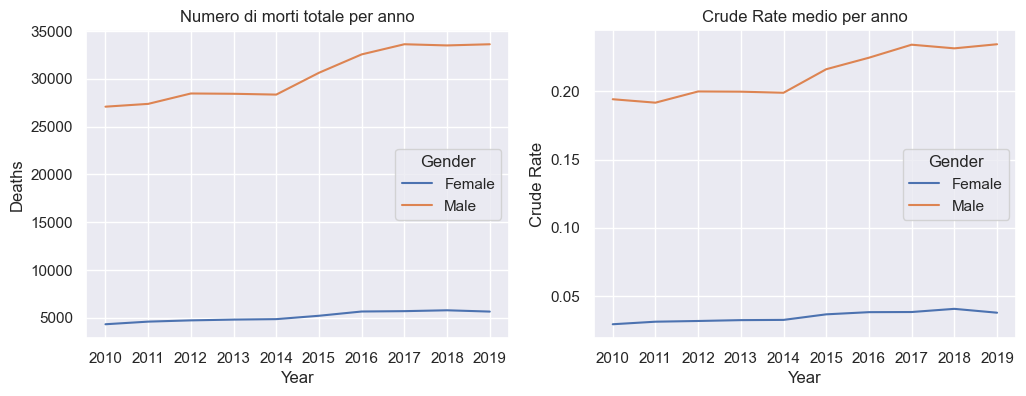

In [22]:
dfCrudeRateByYearGender = dffGender.drop(['State'], axis=1).groupby(by=['Year', 'Gender'], as_index=False).agg({'Deaths':'sum',
                                                                                                                'Population':'sum',
                                                                                                                'Crude Rate':'mean'})
dfCrudeRateByYearGender.head(50)

sns.set(rc={'figure.figsize':(12,4)})
fig, axs = plt.subplots(1,2)
plot2 = sns.lineplot(data=dfCrudeRateByYearGender, x='Year', y='Deaths', hue='Gender', ax=axs[0])
plot2.set(title='Numero di morti totale per anno')
plot2.set(xticks=dfCrudeRateByYear['Year'].values);

plot1 = sns.lineplot(data=dfCrudeRateByYearGender, x='Year', y='Crude Rate', hue='Gender', ax=axs[1])
plot1.set(title='Crude Rate medio per anno')
plot1.set(xticks=dfCrudeRateByYear['Year'].values);

Va da subito osservato come il numero di morti di sesso maschile è notevolemente maggiore rispetto a quello femminile, ma il dato più rilevante è fornito dal secondo grafico, quello riguardante il curde rate. Infatti si nota che comunque, in rapporto alla popolazione, il numero di morti di sesso femminile è minore. 

Passiamo ora ad un'analisi dal punto di vista della composizione etnica della popolazione. Essendo i dati sulle morti per arma da fuoco divisi in base all'etnia, dobbiamo modificare il dataset per per studiare la correlazione della composizione della popolazione e il numero di morti.

In [23]:

dfRaces = dfDemo.pivot_table(index = ['State', 'Gender', 'Year', 
                         dfDemo.groupby(['State', 'Gender', 'Year', 'Race']).cumcount()],
                columns = 'Race',
                values = 'Population')
dfRaces = dfRaces.reset_index()
# per togliere la colonna con gli indici del cumcount, necessario avendo valori multipli
dfRaces = dfRaces.drop(dfRaces.columns[3], axis=1) 

dfRaces = dfRaces.drop('Gender', axis=1).groupby(by=['State', 'Year'], as_index=False).sum()
dfGun = dfGun.drop('Gender', axis=1).groupby(by=['State', 'Year'], as_index=False).sum()

dfRaces = pd.merge(dfGun, dfRaces, how='outer', on=['State','Year'])

dfRaces.head(10)

,State,Year,Deaths,American Indian or Alaska Native,Asian,Black or African American,More than one race,Native Hawaiian or Other Pacific Islander,White
0,Alabama,2010,781,32883.0,55721.0,1261234.0,64873.0,5167.0,3365559.0
1,Alabama,2011,786,32793.0,57527.0,1266978.0,67489.0,5030.0,3369252.0
2,Alabama,2012,832,32863.0,60785.0,1275628.0,70278.0,4970.0,3371064.0
3,Alabama,2013,855,32896.0,63011.0,1284340.0,72730.0,4901.0,3372203.0
4,Alabama,2014,813,33095.0,64943.0,1290579.0,74913.0,4911.0,3373358.0
5,Alabama,2015,955,33332.0,67141.0,1297313.0,77302.0,4916.0,3372343.0
6,Alabama,2016,1037,33610.0,69476.0,1301635.0,79782.0,4916.0,3374106.0
7,Alabama,2017,1122,33840.0,71245.0,1305617.0,82296.0,4961.0,3376527.0
8,Alabama,2018,1064,34281.0,72354.0,1309574.0,84782.0,5048.0,3381642.0
9,Alabama,2019,1072,34799.0,73715.0,1313291.0,86874.0,5110.0,3389396.0


Calcoliamo ora la correlazione tra il numero di abitanti di ogni stato e il numero di morti per arma da fuoco, restringendoci ai singoli anni, per osservare se vi sono variazioni.

In [24]:
races = dfRaces.columns.to_list()
races.remove('Year')
races.remove('State')
races.remove('Deaths')

years = dfRaces['Year'].unique()

for year in years:
    print(year)
    for race in races:
        # dfGun = dfGun[(dfGun['Year']>2009) & (dfGun['Year']<2020)]
        df = dfRaces[dfRaces['Year'] == year]
        corr, p = sci.pearsonr(df[race], df['Deaths'])
        print('\n', race, ': %.3f' % corr)

2010

 American Indian or Alaska Native : 0.619

 Asian : 0.666

 Black or African American : 0.826

 More than one race : 0.774

 Native Hawaiian or Other Pacific Islander : 0.447

 White : 0.937
2011

 American Indian or Alaska Native : 0.616

 Asian : 0.662

 Black or African American : 0.824

 More than one race : 0.776

 Native Hawaiian or Other Pacific Islander : 0.442

 White : 0.933
2012

 American Indian or Alaska Native : 0.602

 Asian : 0.650

 Black or African American : 0.821

 More than one race : 0.770

 Native Hawaiian or Other Pacific Islander : 0.435

 White : 0.929
2013

 American Indian or Alaska Native : 0.597

 Asian : 0.644

 Black or African American : 0.814

 More than one race : 0.765

 Native Hawaiian or Other Pacific Islander : 0.429

 White : 0.924
2014

 American Indian or Alaska Native : 0.591

 Asian : 0.640

 Black or African American : 0.824

 More than one race : 0.763

 Native Hawaiian or Other Pacific Islander : 0.429

 White : 0.921
2015

 American

Dai risultati ottenuti si osserva un'alta correlazione tra la popolazione bianca e il numero di morti, quasi sempre oltre lo 0.9 e in diminuzione negli ultimi 2 anni. Altra osservazione riguarda la componente Afroamericana che oscilla tra lo 0.81 e 0.82.
La correlazione osservata non stupisce essendo le due maggiori componenti della popolazione statunitense.
In conclusione non è possibile fare rilevanti osservazioni con i dati in possesso.